<a href="https://colab.research.google.com/github/hissain/mlworks/blob/main/codes/eng_fr_nn_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## English to French Translation using PyTorch nn.Transformer

French to English translation notebook using PyTorch `nn.Transformer` module.

[Dataset link](https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench).

#Drive Connection


In [ ]:
# connect with drive and current directory where this notebook is located

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd "/content/drive/My Drive/BRTC/Deep Learning/Notebooks/NMT with Transformers"

/content/drive/My Drive/BRTC/Deep Learning/Notebooks/NMT with Transformers


In [ ]:
!ls

eng_fr_nn_transformer.ipynb  input  outputs


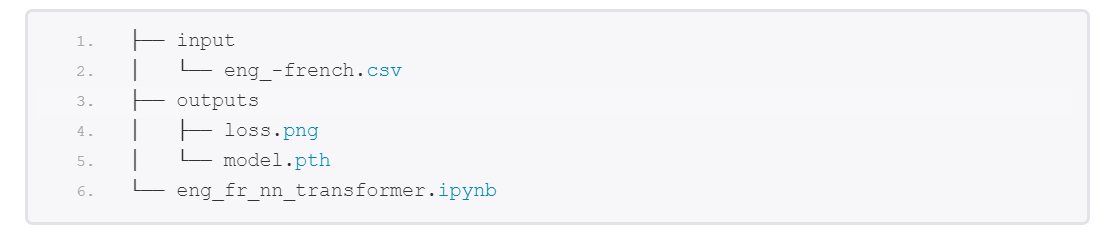

## Setup (one time)

In [ ]:
!pip install -U portalocker
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 59.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Imports

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Dataset Preparation

In [ ]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'fr'

# Place-holders
token_transform = {}
vocab_transform = {}

In [ ]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')

In [ ]:
!ls

drive  sample_data


In [ ]:
csv = pd.read_csv(
    'input/eng_-french.csv',
    usecols=['English words/sentences', 'French words/sentences']
)
csv.head(10)

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
5,Fire!,Au feu !
6,Help!,À l'aide !
7,Jump.,Saute.
8,Stop!,Ça suffit !
9,Stop!,Stop !


In [ ]:
train_csv, test_csv = train_test_split(csv, test_size=0.1)

In [ ]:
print(len(train_csv))
print(len(test_csv))

158058
17563


In [ ]:
train_csv.head()

,English words/sentences,French words/sentences
158383,They kept him waiting outside for a long time.,Ils le firent poireauter dehors.
146722,How much money did you spend on your car?,Combien d'argent avez-vous dépensé pour votre ...
120085,I heard it from a reliable source.,Je l'ai entendu d'une source fiable.
152460,My parents met each other in the mountains.,Mes parents se sont rencontrés dans les montag...
63136,My teacher drove me home.,Mon professeur m'a reconduit chez moi.


In [ ]:
test_csv.head(10)

,English words/sentences,French words/sentences
2785,Take a seat.,Prends place !
29880,I wish Tom was here.,J'aimerais que Tom soit là.
53776,How did the audition go?,Comment s'est passée l'audition ?
154386,I've no friend to talk to about my problems.,Je n'ai pas d'ami avec lequel je puisse m'entr...
149823,I really like this skirt. Can I try it on?,"J'aime beaucoup cette jupe, puis-je l'essayer ?"
38625,What happened to him?,Que lui est-il arrivé ?
85226,Take any two cards you like.,Prends deux cartes de ton choix.
42431,I'm not scared to die.,Je ne crains pas de mourir.
43799,The clock has stopped.,L'horloge s'est arrêtée.
143051,You'd better make sure that it is true.,Tu ferais bien de t'assurer que c'est vrai.


In [ ]:
print(train_csv['French words/sentences'].iloc[100])
print(train_csv['English words/sentences'].iloc[100])

Comment va le chien ?
How's the dog?


In [ ]:
# Custom Dataset class.
class TranslationDataset(Dataset):
    def __init__(self, csv):
        self.csv = csv

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        return(
            self.csv['English words/sentences'].iloc[idx],
            self.csv['French words/sentences'].iloc[idx]
        )

In [ ]:
train_dataset = TranslationDataset(train_csv)
valid_dataset = TranslationDataset(test_csv)

In [ ]:
iterator = iter(train_dataset)
print(next(iterator))

('They kept him waiting outside for a long time.', 'Ils le firent poireauter dehors.')


In [ ]:
# Helper function to yield list of tokens.
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices.
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab.
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Create torchtext's Vocab object.
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_dataset, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# `src` and `tgt` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

## Model and Training Hyperparameters

In [ ]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 192
NHEAD = 6
FFN_HID_DIM = 192
BATCH_SIZE = 192
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = 'cuda'
NUM_EPOCHS = 50

## Prepare Model

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Inputs of forward function
        :param x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [ ]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1
    ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    FFN_HID_DIM
).to(DEVICE)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
print(model)

14,487,719 total parameters.
14,487,719 training parameters.
Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=192, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Tr

## Loss function and optimizer.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def train_epoch(model, optimizer):
    print('Training')
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader, total=len(list(train_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )

        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def evaluate(model):
    print('Validating')
    model.eval()
    losses = 0

    for src, tgt in tqdm(val_dataloader, total=len(list(val_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [ ]:
train_loss_list, valid_loss_list = [], []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    valid_loss = evaluate(model)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s \n"))

Training


  0%|          | 0/824 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 1, Train loss: 5.369, Val loss: 4.181, Epoch time = 102.351s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 2, Train loss: 3.947, Val loss: 3.544, Epoch time = 99.921s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 3, Train loss: 3.480, Val loss: 3.181, Epoch time = 100.433s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 4, Train loss: 3.179, Val loss: 2.927, Epoch time = 103.160s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 5, Train loss: 2.954, Val loss: 2.731, Epoch time = 101.899s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.773, Val loss: 2.568, Epoch time = 103.243s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

KeyboardInterrupt: 

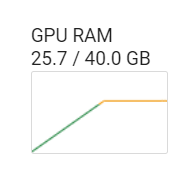

In [ ]:
os.makedirs('outputs', exist_ok=True)

## Plots

In [ ]:
def save_plots(train_loss, valid_loss):
    """
    Function to save the loss plots to disk.
    """
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs', 'loss.png'))
    plt.show()

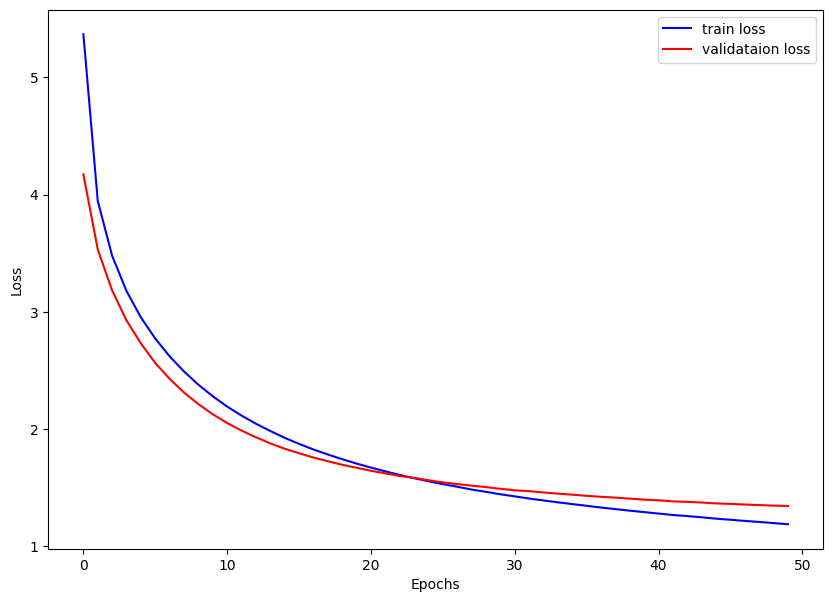

In [ ]:
save_plots(train_loss_list, valid_loss_list)

## Save Model

In [ ]:
torch.save(model, 'outputs/model.pth')

## Inference

In [ ]:
model = torch.load('outputs/model.pth')

In [ ]:
# Helper function to generate output sequence using greedy algorithm.
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if i == 0:
            ys = ys.transpose(1, 0)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys

# Translation function.
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
# SRC, GT pairs from the validation set.
infer_sentences = [
    ["Take a seat.", "Prends place !"],
    ["I'm not scared to die", "Je ne crains pas de mourir."],
    ["You'd better make sure that it is true.", "Tu ferais bien de t'assurer que c'est vrai."],
    ["The clock has stopped.", "L'horloge s'est arrêtée."],
    ["Take any two cards you like.", "Prends deux cartes de ton choix."]
]

In [ ]:
for sentence in infer_sentences:
    print(f"SRC: {sentence[0]}")
    print(f"GT: {sentence[1]}")
    print(f"PRED: {translate(model, sentence[0])}\n")

SRC: Take a seat.
GT: Prends place !
PRED:  Prenez place . 

SRC: I'm not scared to die
GT: Je ne crains pas de mourir.
PRED:  Je ne suis pas effrayé à mourir . 

SRC: You'd better make sure that it is true.
GT: Tu ferais bien de t'assurer que c'est vrai.
PRED:  Tu ferais mieux de faire ça que c' est vrai . 

SRC: The clock has stopped.
GT: L'horloge s'est arrêtée.
PRED:  Le horloge s' est arrêté . 

SRC: Take any two cards you like.
GT: Prends deux cartes de ton choix.
PRED:  Prenez deux cartes comme vous deux . 



# Additional Resources
- https://github.com/gordicaleksa/pytorch-original-transformer/blob/main/The%20Annotated%20Transformer%20%2B%2B.ipynb
